In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_00 import *

In [3]:
train_dl, valid_dl = get_dls(*get_ds(train_glob,valid_glob), bs = 8)
data = DataBunch(train_dl,valid_dl)
loss_func = nn.MSELoss()

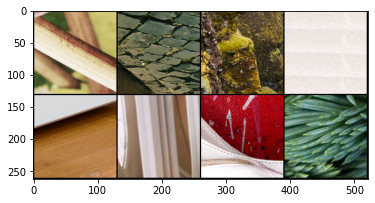

In [4]:
data.train_dl.show_batch()

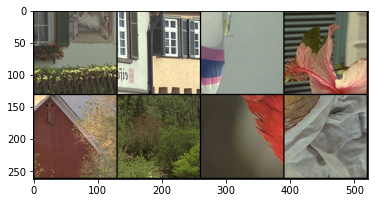

In [5]:
data.valid_dl.show_batch()

In [6]:
#export
import torch.nn.functional as F

In [7]:
#export
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

In [8]:
#export
def conv(ni, nf, ks=3, stride=1, padding=1, **kwargs):
    _conv = nn.Conv2d(ni, nf, kernel_size=ks,stride=stride,padding=padding, **kwargs)
    nn.init.kaiming_normal_(_conv.weight)
    nn.init.zeros_(_conv.bias)
    return _conv

In [9]:
#export
def get_stats(w):
    return w.mean(), w.std()

In [10]:
#export
class ResBlock(nn.Module):
    def __init__(self, ni, nh=128):
        super().__init__()
        
        self.conv1 = conv(ni, nh)
        self.conv2 = conv(nh, ni)
        #initilize 2nd conv with zeros to preserve variance
        nn.init.zeros_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)

    def forward(self, x):
        return x  + self.conv2(F.relu(self.conv1(x)))

In [11]:
resblock = ResBlock(3)
get_stats(resblock.conv1.weight)

(tensor(-0.0024, grad_fn=<MeanBackward0>),
 tensor(0.2728, grad_fn=<StdBackward0>))

In [12]:
assert get_stats(resblock.conv2.weight) == (0.,0.)

In [13]:
inp = torch.randn(1,3,128,128)
out = resblock(inp)
assert out.shape == inp.shape

In [14]:
# check identity mapping at the start of training in residual block
assert get_stats(inp) == get_stats(out)

In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        layers= [conv(3, 128, 8, 4, 2), nn.ReLU(),
                     ResBlock(128), nn.ReLU(),
                     conv(128, 256, 4, 2, 1), nn.ReLU(),
                     ResBlock(256), nn.ReLU(),
                     ResBlock(256),
                     conv(256, 64, 3, 1, 1),
                     nn.Sigmoid()]
        
        self.stem = nn.Sequential(*layers)
        nn.init.xavier_normal_(self.stem[9].weight)
        
    def forward(self,x):
        return self.stem(x)

In [16]:
from torchinfo import summary

In [17]:
enc = Encoder()
enc

Encoder(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): ResBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ResBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (7): ReLU()
    (8): ResBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (9): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
)

In [18]:
num_params = sum(p.numel() for p in enc.parameters())
num_params_train = sum(p.numel() for p in enc.parameters() if p.requires_grad)

In [19]:
summary(enc, (1,3,128,128), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  --                        --
├─Sequential: 1-1                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 128, 32, 32]          24,704
│    └─ReLU: 2-2                         [1, 128, 32, 32]          --
│    └─ResBlock: 2-3                     [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-1                  [1, 128, 32, 32]          147,584
│    │    └─Conv2d: 3-2                  [1, 128, 32, 32]          147,584
│    └─ReLU: 2-4                         [1, 128, 32, 32]          --
│    └─Conv2d: 2-5                       [1, 256, 16, 16]          524,544
│    └─ReLU: 2-6                         [1, 256, 16, 16]          --
│    └─ResBlock: 2-7                     [1, 256, 16, 16]          --
│    │    └─Conv2d: 3-3                  [1, 128, 16, 16]          295,040
│    │    └─Conv2d: 3-4                  [1, 256, 16, 16]    

In [20]:
#export
class Binarizer(torch.autograd.Function):
    @staticmethod 
    def forward(ctx, i):
        if i.is_cuda: return torch.where(i > 0.5, tensor(1.).cuda(), tensor(0.).cuda())
        return torch.where(i > 0.5, tensor(1.), tensor(0.))

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

def bin_values(x):
    return Binarizer.apply(x)

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [21]:
#export
class Binarizer(torch.autograd.Function):
    @staticmethod 
    def forward(ctx, i):
        return (i>0.5).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

def bin_values(x):
    return Binarizer.apply(x)

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [22]:
a = tensor([.34, .12, .67, .89, .01, 0.5])

In [23]:
(a>0.5).float()

tensor([0., 0., 1., 1., 0., 0.])

In [24]:
torch.where(a > 0.5, tensor(1.), tensor(0.))

tensor([0., 0., 1., 1., 0., 0.])

In [25]:
a

tensor([0.3400, 0.1200, 0.6700, 0.8900, 0.0100, 0.5000])

In [26]:
a = torch.rand(4,4,requires_grad=True)
print(a)

tensor([[0.1537, 0.8984, 0.5922, 0.4273],
        [0.8630, 0.0105, 0.0801, 0.0451],
        [0.1022, 0.3488, 0.9367, 0.1356],
        [0.5974, 0.3401, 0.9861, 0.6447]], requires_grad=True)


In [27]:
a.device

device(type='cpu')

In [28]:
b = bin_values(a)
print(a)
print(b)

tensor([[0.1537, 0.8984, 0.5922, 0.4273],
        [0.8630, 0.0105, 0.0801, 0.0451],
        [0.1022, 0.3488, 0.9367, 0.1356],
        [0.5974, 0.3401, 0.9861, 0.6447]], requires_grad=True)
tensor([[0., 1., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 1., 1.]], grad_fn=<BinarizerBackward>)


In [29]:
loss = b.sum()
print('Loss:{}'.format(loss))

Loss:7.0


In [30]:
loss.backward()
a.grad

/home/adityassrana/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [31]:
#export
class Encoder(nn.Module):
    def __init__(self, return_imp_map=False):
        super(Encoder, self).__init__()
        self.return_imp_map = return_imp_map
        self.stem = nn.Sequential(conv(3, 128, 8, 4, 2), nn.ReLU(),
                                 ResBlock(128), nn.ReLU(),
                                 conv(128, 256, 4, 2, 1), nn.ReLU(),
                                 ResBlock(256), nn.ReLU(),
                                 ResBlock(256), nn.ReLU())

        self.head = nn.Sequential(conv(256, 64, 3, 1, 1), 
                                   nn.Sigmoid(),
                                   Lambda(bin_values))
         
        
        self.imp_map_extractor = nn.Sequential(conv(256,128), nn.ReLU(),
                                                conv(128,128),nn.ReLU(),
                                                conv(128,1), nn.Sigmoid())
        
        #initiating layers before Sigmoid with Xavier
        nn.init.xavier_normal_(self.head[0].weight)
        nn.init.xavier_normal_(self.imp_map_extractor[4].weight)
        
    def extra_repr(self):
        params = sum(p.numel() for p in self.parameters())
        return f'Total Params: {params}'
    
    def forward(self, x):
        stem = self.stem(x)
        if self.return_imp_map:
            return self.head(stem), self.imp_map_extractor(stem)
        else:
            return self.head(stem)

In [32]:
!python notebook2script.py 01_encoder.ipynb

Converted 01_encoder.ipynb to exp/nb_01.py
